In [22]:
import time
import torch.optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
from datasets.dataset import CUBDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
from numpy import unravel_index
from collections import Counter, defaultdict

# declaration

In [23]:
N_parts = 5

In [24]:
trainset = CUBDataset()
trainloader = DataLoader(dataset=trainset, batch_size=10, shuffle=True)
testset = CUBDataset(is_test = True)
testloader = DataLoader(dataset=testset, batch_size=10, shuffle=True)

In [25]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)

Using cache found in C:\Users\Vincent/.cache\torch\hub\pytorch_vision_v0.9.0


In [ ]:
vgg19.feature

In [5]:
def part_based_features(feature_channels, M):
    """
    Pi(X) =c∑j=1([W∗X]j·Mi)
    """
    P = list()
    for mi in M:
        pi = sum(feature_channel @ mi for feature_channel in feature_channels)
        P.append(pi.unsqueeze(0))
    return torch.cat(P)

In [27]:
def attention_map(feature_channels, d):
    """
    i = n-th Part
    j = 1..c
    Mi(X) = sigmoid(∑dji[W∗X]j)
    W∗X = j-th feature channel
    dji = j-th weight vector
    """
    M = 0
    for i in range(feature_channels.size(0)):
        M += d[i] * feature_channels[i]
    M = torch.sigmoid(M)
    return M

In [28]:
def loss_CNG(M, t):
    """
    Input are the coordinates of the position vector "t" and all attention maps of one image "M".
    Lcng(Mi) =Dis(Mi) +λDiv(Mi)
    The λ in Eqn. (7) and mrg in Eqn. (9) are empirically set to 2 and 0.02.
    """
    weight = 2
    margin = .02
    loss = list()
    
    def distance(mi, ix, iy, i, t):
        """Dis(Mi) =∑(x,y)∈Mi(mi(x, y)[||x−tx||2+||y−ty||2])"""
        tx, ty = list(zip(*t))
        tx, ty = np.array(tx), np.array(ty)
        euclidean_norm = lambda x: np.sqrt(sum(elm**2 for elm in x))
        return mi[iy,ix] * (euclidean_norm(ix - tx)** 2 + euclidean_norm(iy - ty)**2)

    def diversity(M, i, ix, iy, mrg):
        """Div(Mi) =∑(x,y)∈Mi(mi(x, y)[max(k/=im)_k(x, y)−mrg])"""
        return M[i][iy,ix] * (max([M[k][iy,ix] for k in range(len(M)) if k != i]) - mrg)
    
    for i, mi in enumerate(M):
        dis = 0
        div = 0
        for iy in range(mi.size(0)):
            for ix in range(mi.size(1)):
                dis += distance(mi, ix, iy, i, t)
                div += diversity(M, i, ix, iy, margin)
        loss.append(dis + weight * div)

    return loss

In [29]:
class Net(nn.Module):
    """
    Part NN
    FC Layers which produce a weight vector d_i(X) from [d_1 .. d_c], where c is the length of feature channels.
    Takes as input convolutional features which gets represented as positional vectors t.
    """
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 512)
    
    def forward(self, t):
        """
        t = position vector
        d = weight vector
        """
        d = self.fc1(t)
        d = self.fc2(d)
        return d

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)
        self.vgg19.classifier[0] = nn.Linear(in_features=980, out_features=4096, bias=True)
        self.vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)
        
    def forward(self, x):
        x = x.view(1,980)
        x = self.vgg19.classifier(x)
        x = nn.Softmax(dim=0)(x)
        return x

# channel grouping

### Normalization

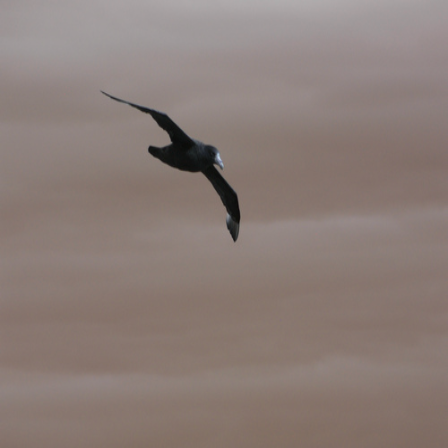

In [88]:
# TODO add to preprocessing
base_img , label = trainset[100]
Image.fromarray(base_img.transpose(1,2,0).astype(np.uint8), 'RGB')

torch.Size([1, 3, 448, 448])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


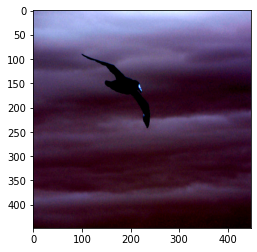

In [89]:
img = transforms.ToTensor()(base_img)
img = img.permute(1,2,0)
img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
img = img.unsqueeze(0)
print(img.shape)
plt.imshow(img.squeeze(0).permute(1,2,0))

### Calculate position vector "t"

In [90]:
channels = vgg19.features(img)

coordinates = list()
for channel in channels.detach().numpy()[0]:
    coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]

t_flat = [point for coordinate in coordinates for point in coordinate]
t_flat = torch.FloatTensor(t_flat)

In [91]:
threshold = 150
patters = [channels[0,i].detach().numpy() for i in range(channels.size(1))]
patters2 = [patter for patter in patters if np.argmax(patter) > threshold]
print(len(patters2), patters2[0].shape)

18 (14, 14)


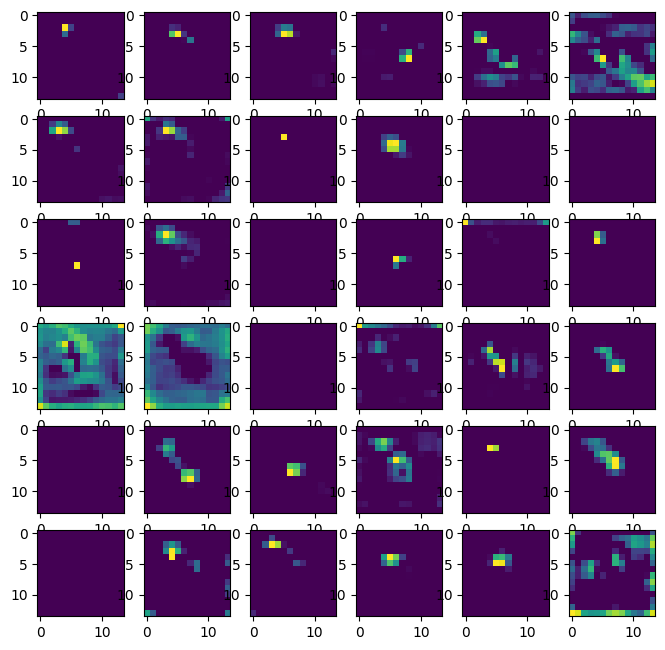

In [101]:
f, axarr = plt.subplots(6,6, figsize=(8,8), dpi= 100)
counter = 0

for i, _ in enumerate(axarr):
    for j, _ in enumerate(axarr[i]):
        axarr[i,j].imshow(patters[counter])
        counter += 1

In [102]:
# Initiate N-times neural networks (Part FC's)
NNs = {N: Net() for N in range(N_parts)}

In [103]:
M = list()
for N in range(N_parts):
    
    # Calculate weight vector "d"
    d = NNs[N](t_flat)

    # Calculate attention map "M"
    mi = attention_map(channels[0], d)
    M.append(mi)

### Calculate Loss CNG of all Mi's "L_cng(M_i)"

In [105]:
M_loss_cng = loss_CNG(M, coordinates)
M_loss_cng

[tensor(1040252.0625, grad_fn=<AddBackward0>),
 tensor(3339103.5000, grad_fn=<AddBackward0>),
 tensor(211989.1094, grad_fn=<AddBackward0>),
 tensor(529089.8750, grad_fn=<AddBackward0>),
 tensor(1254467.3750, grad_fn=<AddBackward0>)]

### Spatial Pooling

In [106]:
P = part_based_features(channels[0], M)
P.shape

torch.Size([5, 14, 14])

# Classification

In [107]:
loss_clf = nn.CrossEntropyLoss()

In [108]:
vgg19.classifier[0] = nn.Linear(in_features=980, out_features=4096, bias=True)
vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=200, bias=True)

In [109]:
nn.Softmax(dim=0)(vgg19.classifier(P.view(980))).shape

torch.Size([200])

# Parts model

In [110]:
NNs = {N: Net() for N in range(N_parts)}

In [111]:
epochs = 10
optimizers = dict()

for epoch in range(epochs):
    for imgs, label in trainloader:
        for img in imgs:
            img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
            img = img.unsqueeze(0)
            channels = vgg19.features(img)
            coordinates = list()
            for channel in channels.detach().numpy()[0]:
                coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
            t_flat = [point for coordinate in coordinates for point in coordinate]
            t_flat = torch.FloatTensor(t_flat)
            M = list()
            for N in range(N_parts):      
                # Calculate weight vector "d"
                d = NNs[N](t_flat)
                optimizers[N] = torch.optim.Adam(NNs[N].parameters(), lr = 0.01)

                # Calculate attention map "M"
                mi = attention_map(channels[0], d)
                M.append(mi)

            l_cng = torch.tensor(loss_CNG(M, coordinates), requires_grad = True)

            for i, l in enumerate(l_cng):
                l.backward(retain_graph=True)

            for N in range(N_parts): 
                optimizers[N].step()
                optimizers[N].zero_grad()
        
    print(l_cng,"\n")


tensor([4716682.0000, 2710343.2500, 5022420.0000, 4846730.5000,  477259.3438],
       requires_grad=True) 

tensor([3284433.7500, 1527153.5000, 2611510.5000, 2746881.2500, 2892930.5000],
       requires_grad=True) 

tensor([3608036.5000, 5454309.5000, 1949407.8750, 4259876.0000, 1025185.8750],
       requires_grad=True) 

tensor([4166016.5000, 4859517.5000, 1886832.1250, 3488650.7500, 3017153.5000],
       requires_grad=True) 

tensor([3347068.7500, 1786932.5000, 3015921.5000, 1968291.6250, 2979042.5000],
       requires_grad=True) 

tensor([4008424.7500, 4235379.5000, 3237091.5000, 2911838.7500, 4428284.0000],
       requires_grad=True) 

tensor([5736296.0000, 4694923.5000, 4558474.0000, 4090536.2500,  895922.0625],
       requires_grad=True) 



KeyboardInterrupt: 

In [ ]:
for N in NNs:
    filepath = f'models/part{N}.pth'
    torch.save(NNs[N], filepath)

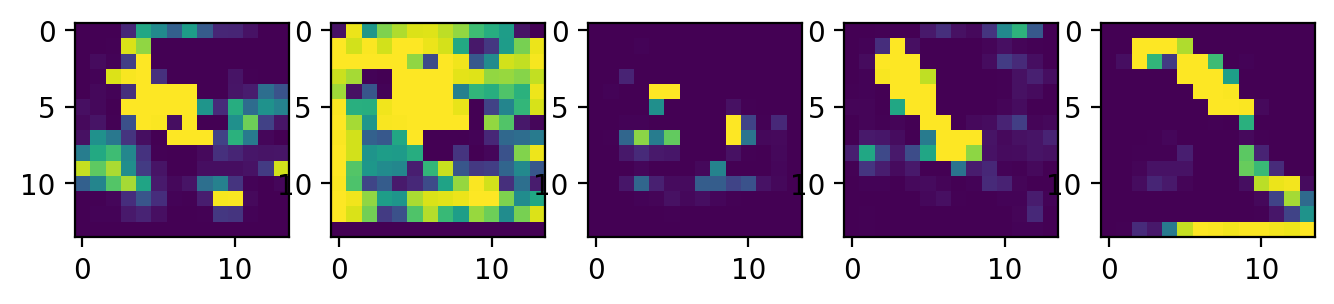

In [104]:
f, axarr = plt.subplots(1,5, figsize=(8,8), dpi= 200)

for i, mi in enumerate(M):
    axarr[i].imshow(mi.detach().numpy())

In [32]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)
        self.vgg19.classifier[0] = nn.Linear(in_features=980, out_features=4096, bias=True)
        self.vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)
        
    def forward(self, x):
        x = x.view(1,980)
        x = self.vgg19.classifier(x)
        x = nn.Softmax(dim=0)(x)
        
        return x

In [33]:
classifier = Classifier()

In [34]:
save_classifier_model = 'models/classifier.pth'

In [35]:
epochs = 10
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.01)
for epoch in range(epochs):
    for imgs, labels in trainloader:
        for i, img in enumerate(imgs):
            label = labels[i:i+1]
            img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
            img = img.unsqueeze(0)
            channels = vgg19.features(img)
            coordinates = list()
            for channel in channels.detach().numpy()[0]:
                coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
            t_flat = [point for coordinate in coordinates for point in coordinate]
            t_flat = torch.FloatTensor(t_flat)
            M = list()
            for N in range(N_parts):      
                # Calculate weight vector "d"
                part = torch.load(f'models/part{N}.pth')
                d = part(t_flat)
                # Calculate attention map "M"
                mi = attention_map(channels[0], d)
                M.append(mi)

            l_cng = torch.tensor(loss_CNG(M, coordinates), requires_grad = True)
            P = part_based_features(channels[0], M)
    
            output = classifier(P)
        
         #   prediction = torch.argmax(output)
            loss = l_cng + loss_clf(output, label.long())
            
            for i, l in enumerate(l_cng):
                l.backward(retain_graph=True)
 
            optimizer.step()
            optimizer.zero_grad()
        
    print(loss,"\n")


tensor([ 249592.7500, 2355497.7500, 3536901.0000, 3946479.7500, 1077009.0000],
       grad_fn=<AddBackward0>) 

tensor([1883096.1250, 3041310.2500, 1002922.1875, 2370028.0000, 2152381.5000],
       grad_fn=<AddBackward0>) 

tensor([2883294.0000, 2832995.0000, 3093154.0000,  771162.6875, 2882391.2500],
       grad_fn=<AddBackward0>) 

tensor([3405203.2500,  898191.8750, 2930962.5000, 3873893.5000, 3087555.5000],
       grad_fn=<AddBackward0>) 

tensor([1973482.1250, 3222752.2500, 3789137.5000, 2974842.7500, 4509590.5000],
       grad_fn=<AddBackward0>) 

tensor([4138853.5000, 3936995.5000, 3482432.5000, 3329948.2500, 4459486.5000],
       grad_fn=<AddBackward0>) 

tensor([4537684.5000, 4031375.5000, 3587804.0000, 1828229.7500, 3153385.7500],
       grad_fn=<AddBackward0>) 

tensor([2025211.2500, 2427974.5000, 4709726.0000, 1319464.3750, 1514840.2500],
       grad_fn=<AddBackward0>) 

tensor([1950500.2500, 3634619.0000, 3181980.5000,  958434.6250, 2487726.0000],
       grad_fn=<AddBackwa

In [36]:
torch.save(classifier, save_classifier_model)

# Testing

In [37]:
cnn = torch.load('models/classifier.pth')

In [ ]:
img , label = trainset[120]

In [43]:
for imgs, labels in testloader:
    for i, img in enumerate(imgs):
        label = labels[i:i+1]
        img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
        img = img.unsqueeze(0)
        channels = vgg19.features(img)
        coordinates = list()
        for channel in channels.detach().numpy()[0]:
            coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
        t_flat = [point for coordinate in coordinates for point in coordinate]
        t_flat = torch.FloatTensor(t_flat)
        M = list()
        for N in range(N_parts):      
            # Calculate weight vector "d"
            part = torch.load(f'models/part{N}.pth')
            d = part(t_flat)
            # Calculate attention map "M"
            mi = attention_map(channels[0], d)
            M.append(mi)

        l_cng = torch.tensor(loss_CNG(M, coordinates), requires_grad = True)
        P = part_based_features(channels[0], M)

        output = cnn(P)

        loss = l_cng + loss_clf(output, label.long())

        prediction = 0
        index = 0
        for i, o in enumerate(output[0]):
            if o > prediction:
                prediction = o
                index = i

        print("Prediction:",index,"Ground truth:", label[0].item())

print(loss,"\n")


Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 3
Prediction: 0 Ground truth: 2
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction: 0 Ground truth: 0
Prediction: 0 Ground truth: 1
Prediction

In [ ]:
epochs = 10
optimizers = dict()

for epoch in range(epochs):
    M = list()
    for N in range(N_parts):      
        # Calculate weight vector "d"
        d = NNs[N](t_flat)
        optimizers[N] = torch.optim.Adam(NNs[N].parameters(), lr = 0.01)

        # Calculate attention map "M"
        mi = attention_map(channels[0], d)
        M.append(mi)
    l_cng = torch.tensor(loss_CNG(M, coordinates))
    
    P = part_based_features(channels[0], M)
    
    output = nn.Softmax(dim=0)(vgg19.classifier(P.view(1,980)))
    
    loss = l_cng + loss_clf(output, torch.tensor([5]))
    for i, l in enumerate(loss):
        l.backward(retain_graph=True)
    
    for N in range(N_parts): 
        optimizers[N].step()
        optimizers[N].zero_grad()
        
    print(loss,"\n")


In [ ]:
epochs = 10

for epoch in range(epochs):
    running_loss = defaultdict(float)
    counter = 0
    for imgs, label in testloader:
        for img in imgs:
            optimizer = torch.optim.Adam(NNs[N].parameters(), lr = 0.01)
            optimizer.zero_grad()
            img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img/255) 
            img = img.unsqueeze(0)
            channels = vgg19.features(img)
            coordinates = list()
            for channel in channels.detach().numpy()[0]:
                coordinates = coordinates + [unravel_index(channel.argmax(), channel.shape)]
            t_flat = [point for coordinate in coordinates for point in coordinate]
            t_flat = torch.FloatTensor(t_flat)
            M = list()
            for N in range(N_parts):
                # Calculate weight vector "d"
                d = NNs[N](t_flat)

                # Calculate attention map "M"
                mi = attention_map(channels[0], d)
                M.append(mi)
            loss = loss_CNG(M, coordinates)
            for i, l in enumerate(loss):
                running_loss[i] += l
                l.backward(retain_graph=True)
            

        
            optimizer.step()
            counter +=1
    print([l/counter for l in running_loss.values()],"running_loss: ",running_loss," counter: ",counter,"\n")
    


In [ ]:
x = defaultdict(int)

In [ ]:
x[0] += 1
x

In [ ]:
t_flat.backward()

In [ ]:
learning_rate = 1e-3
input_channels = 1
output_features = 6
epoch = 1
save_model_name = 'models/pretrained.pth'

In [ ]:
trainset = CUBDataset()
trainloader = DataLoader(dataset=trainset, batch_size=10, shuffle=True)
testset = CUBDataset(is_test = True)
testloader = DataLoader(dataset=testset, batch_size=10, shuffle=True)

In [ ]:
vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)

# Standard Vgg19

In [ ]:
img , label = trainset[120]
print(img.shape)
print(img.transpose(1,2,0).shape)
baseimage = Image.fromarray(img.transpose(1,2,0).astype(np.uint8))
baseimage


In [ ]:
img = transforms.ToTensor()(img)
img = img.permute(1,2,0)
mean, std = img.mean([1,2]), img.std([1,2])
#print("Mean:", mean, "\nStd:", std)
#print("image shape:", img.shape)
#img = transforms.Normalize(mean, std)(img)
#/255 -> Vgg19 Normalization
img = img/255
img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img) 
img = img.unsqueeze(0)
print(img.shape)

In [ ]:
vgg19(img)

In [ ]:
output = nn.Softmax(dim=1)(vgg19(img))

In [ ]:
with open("classes_vgg19.txt","r") as f:
    classes = f.read().split("\n")

In [ ]:
max_o = 0
highscore = None
for i, o in enumerate(output[0]):
    if max_o < o:
        highscore = i
        max_o = o

print(highscore,classes[highscore])

In [ ]:
channels = vgg19.features(img)
channels = channels.detach().numpy()

In [ ]:
square = 5
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(channels[0, ix-1, :, :], cmap='gray')
        ix += 1
# show the figure
pyplot.show()


# Formula 1: determine t

In [ ]:
t = list()
for channel in channels[0]:
    #print(np.max(channel))
    t.append(unravel_index(channel.argmax(), channel.shape))

In [ ]:
x,y = zip(*t)

In [ ]:
x_list = list()
y_list = list()
for x,y in t:
    x_list.append(x)
    y_list.append(y)
  

In [ ]:
plt.scatter(x_list,y_list)

In [ ]:
counter = Counter(t)

In [ ]:
part_xy = counter.most_common(20)[1:]

In [ ]:
part_xy

In [ ]:
for xy,_ in part_xy:
    x,y = xy
    i = ImageDraw.Draw(baseimage).rectangle([(x-1)*32,(y-1)*32,x*32,y*32])
baseimage

In [ ]:

i = ImageDraw.Draw(baseimage)
i.rectangle([1,1,32,32])

In [ ]:
i = 0

In [ ]:
baseimage

# Clustering

In [ ]:
class Clustering(nn.Module):
    
    def __init__(self):
        super(Clustering, self).__init__()
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        

In [ ]:
t_flatten = [i for xy in t for i in xy]

In [ ]:
t_flatten= torch.Tensor(t_flatten)

In [ ]:
t_flatten.shape

In [ ]:
vgg19.fc1 = nn.Linear(in_features=1024, out_features=512, bias=True)
vgg19.fc2 = nn.Linear(in_features=512, out_features=512, bias=True)
#vgg19.fc(torch.Tensor(t).permute(1,0))
vgg19.fc2(vgg19.fc1(t_flatten))

In [ ]:
vgg19.eval

In [ ]:
class Part(nn.Module):

    def __init__(self):
        super(Part, self).__init__()
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256)

    def forward(self, x):
        conv_matrix = torch.clone(x)
        conv_matrix = conv_matrix.reshape(conv_matrix.size(0), 512, 1, 784) #512 = patterns; 784 = 28x28 pattern w x h
        conv_matrix = conv_matrix.transpose(1, 3)
        x = F.avg_pool2d(x, kernel_size=28, stride=28)
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x).unsqueeze(1).unsqueeze(1)
        x = F.interpolate(x, (1, 784), mode='bilinear', align_corners=True)
        x = x.squeeze(1).squeeze(1).unsqueeze(2).unsqueeze(3)
        x = x * conv_matrix
        x = F.avg_pool2d(x, kernel_size=(1, 512), stride=512)
        x = x * 0.1
        x = F.softmax(x, dim=1)
        x = torch.exp(x)
        x = x + 1
        x = torch.log(x)
        x = x * 4
        x = x.squeeze(2).squeeze(2)
        return x.reshape(x.size(0), 28, 28)

In [ ]:
class Loss(nn.Module):

    def __init__(self):
        super(Loss, self).__init__()

    def forward(self, tensor):
        loss_sum = torch.zeros(1).cuda()
        indexes = Loss.get_max_index(tensor)
        for i in range(len(indexes)):
            max_x, max_y = indexes[i]
            for j in range(tensor.size(1)):
                for k in range(tensor.size(2)):
                    loss_sum += ((max_x - j) * (max_x - j) + (max_y - k) * (max_y - k)) * tensor[i, j, k]
        return loss_sum

    @staticmethod
    def get_max_index(tensor):
        shape = tensor.shape
        indexes = []
        for i in range(shape[0]):
            mx = tensor[i, 0, 0]
            x, y = 0, 0
            for j in range(shape[1]):
                for k in range(shape[2]):
                    if tensor[i, j, k] > mx:
                        mx = tensor[i, j, k]
                        x, y = j, k
            indexes.append([x, y])
        return indexes

In [ ]:
part = Part()

In [ ]:
loss_fn = Loss()

In [ ]:
optimizer = torch.optim.Adam(part.parameters(), lr = learning_rate)

In [ ]:
img , label = trainset[55]
Image.fromarray(img.transpose(1,2,0).astype(np.uint8))

In [ ]:
img = transforms.ToTensor()(img)
img = img.permute(1,2,0)
print(img.shape)
mean, std = img.mean([1,2]), img.std([1,2])
print("Mean:", mean, "\nStd:", std)
img = img/255
img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img)
img = img.unsqueeze(0)
print("image shape:", img.shape)

In [ ]:
channels = vgg19.features[0:36](img)

In [ ]:
print("channel shape:", channels.shape)
output = part(channels)
print("output shape:", output.shape)
optimizer.zero_grad()
loss = loss_fn(output)
loss.backward()
optimizer.step()
print("hi")

In [ ]:
part_model = torch.load(save_model_name)

In [ ]:
output = part_model(channels)
x = output.permute(1,2,0).detach().numpy()
print(x.shape)
print(type(x))
print(np.stack((x,x,x),axis=2).squeeze(-1).shape)
Image.fromarray(np.stack((x,x,x),axis=2).squeeze(-1).astype(np.uint8))


In [ ]:
epoch = 10
for epoch_number in range(epoch):
    running_loss, count, acc = 0., 0, 0.
    for batch, label in trainloader:
        for img in batch:
            t = time.time()
            #print(img.shape)
            img = img/255
            img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img)
            img = img.unsqueeze(0)
            #print("image shape:", img.shape)
            channels = vgg19.features[0:36](img)
            #print("channel shape:", channels.shape)
            output = part(channels)
            #print("output shape:", output.shape)
            optimizer.zero_grad()
            loss = loss_fn(output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count += img.size(0)
            #print(time.time() - t)
        print(epoch_number, count, running_loss, Loss.get_max_index(output))

           


In [ ]:
torch.save(part, save_model_name)